# **임대주택 단지 내 적정 주차수요 예측 대회**

In [1]:
PATH = r'C:\Users\Wyatt\wyatt37\data\parking'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

In [168]:
age_gender = pd.read_csv(PATH + '\\new_age_gender_info.csv')
train = pd.read_csv(PATH + '\\new_train.csv')
test = pd.read_csv(PATH + '\\new_test.csv')
sub = pd.read_csv(PATH + '\\new_sample_submission.csv')

# PREPROCESSING

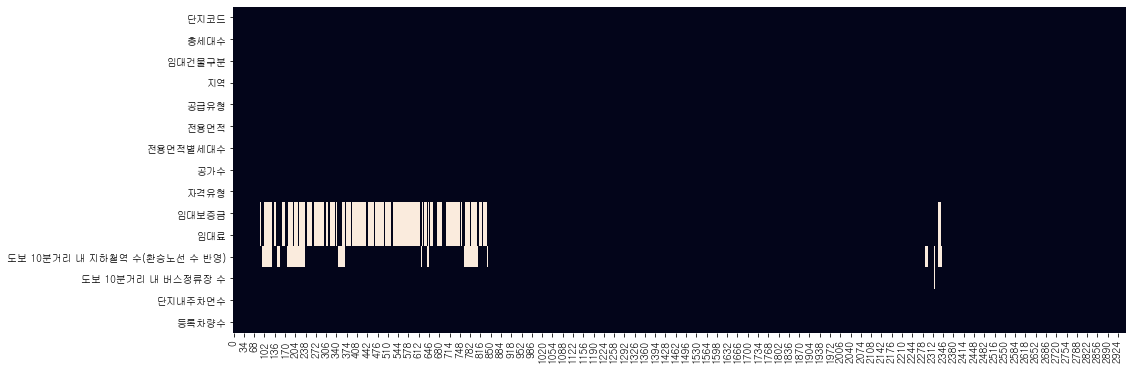

In [169]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

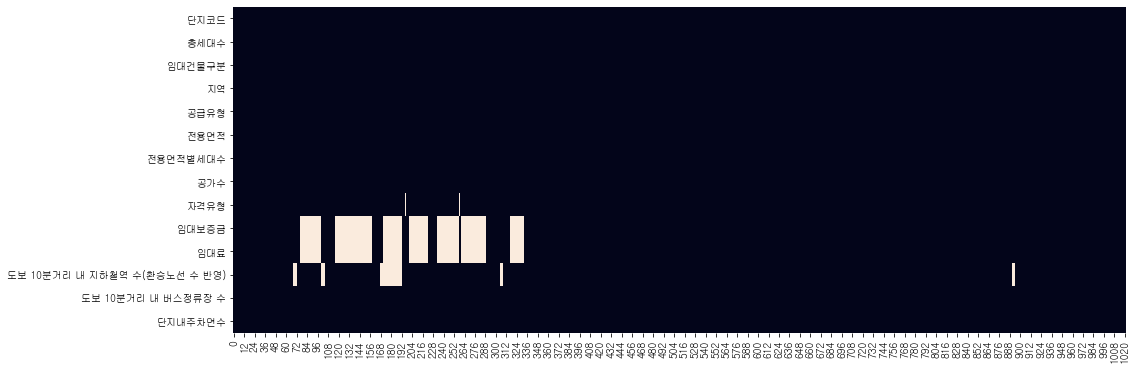

In [170]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

## FILLNA

### Subway

In [171]:
# train set에 지하철 정보가 없는 경남, 충남은 0으로 보간
train.loc[(train['지역'].isin(['경상남도', '충청남도'])) & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = 0

In [172]:
# LH청약센터에서 찾은 주소로 확인한 대전의 8개 단지는 지하철이 없음
# 0으로 채워줍시다.

(train.loc[(train['지역'] == '대전광역시')
           & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull())
           , '도보 10분거리 내 지하철역 수(환승노선 수 반영)']) = 0

In [173]:
# test set에 지하철 정보가 없는 충남은 0으로 보간
test.loc[(test['지역'].isin(['충청남도'])) & (test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull()), '도보 10분거리 내 지하철역 수(환승노선 수 반영)'] = 0

In [174]:
# LH청약센터에서 찾은 주소로 확인한 대전의 2개 단지는 지하철이 없음
# 0으로 채워줍시다.

(test.loc[(test['지역'] == '대전광역시')
           & (test['도보 10분거리 내 지하철역 수(환승노선 수 반영)'].isnull())
           & (test['임대건물구분'] != '상가'), '도보 10분거리 내 지하철역 수(환승노선 수 반영)']) = 0

### Bus

In [175]:
# 버스정류장 결측치는 train set에 1개 단지에 존재
# 해당 단지는 양산신도시LH아파트 5단지
# 지도를 확인한 결과 보수적으로 잡아도 7개 이상

train['도보 10분거리 내 버스정류장 수'] = train['도보 10분거리 내 버스정류장 수'].fillna(7)

### Rent

In [176]:
# test set 에 임대보증금과 임대료가 결측치인 1개 단지 존재
# 해당 단지는 대전둔산1단지주공아파트
# 공고문에 의거, 임대보증금과 임대료 아래와 같이 보간

test.loc[(test['임대건물구분'] != '상가') & (test['임대보증금'].isnull()), '임대보증금'] = [5787000, 5787000, 11574000]
test.loc[(test['임대건물구분'] != '상가') & (test['임대료'].isnull()), '임대료'] = [79980, 79980, 159960]

### Qualification

In [177]:
# C2411 아파트의 자격유형은 전부 A로 되어 있음.
# 동일하게 A로 보간

test.loc[(test['단지코드'] == 'C2411') & (test['자격유형'].isnull()), '자격유형'] = 'A'

In [178]:
# C2253 아파트의 자격유형은 전부 C로 되어 있음.
# 동일하게 C로 보간

test.loc[(test['단지코드'] == 'C2253') & (test['자격유형'].isnull()), '자격유형'] = 'C'

## VALUE PREPROCCESSING

### StdDeposit(환산보증금)

In [179]:
train.loc[train['임대보증금'] == '-', '임대보증금'] = 0
test.loc[test['임대보증금'] == '-', '임대보증금'] = 0

train.loc[train['임대료'] == '-', '임대료'] = 0
test.loc[test['임대료'] == '-', '임대료'] = 0

In [180]:
# nan 값 때문에 object로 되어 있습니다. 일단 0으로 채워 줍니다.
train['임대보증금'] = train['임대보증금'].fillna(0)
test['임대보증금'] = test['임대보증금'].fillna(0)

train['임대료'] = train['임대료'].fillna(0)
test['임대료'] = test['임대료'].fillna(0)

In [181]:
# 계산을 위해서 int로 바꿔줍니다.
train['임대보증금'] = train['임대보증금'].astype(int)
test['임대보증금'] = test['임대보증금'].astype(int)

train['임대료'] = train['임대료'].astype(int)
test['임대료'] = test['임대료'].astype(int)

- 환산보증금은 보증금 + 임대료 * 100 입니다.

In [182]:
# 환산보증금 컬럼을 만들어줍니다.
train['환산보증금'] = train['임대보증금'] + train['임대료'] * 100
test['환산보증금'] = test['임대보증금'] + test['임대료'] * 100

In [183]:
# 제곱미터당 환산보증금을 만들어줍니다.
train['면적당환산보증금'] = (train['환산보증금'] / train['전용면적']).round()
test['면적당환산보증금'] = (test['환산보증금'] / test['전용면적']).round()

- 임대료가 없는 아파트를 찾아서 값을 넣어주겠습니다.

In [184]:
# C1350은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1350') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [185]:
# C1786은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C1786') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [186]:
# C2186은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] == 0), '면적당환산보증금'] = train.loc[(train['단지코드'] == 'C2186') & (train['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [187]:
# C1326은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
train.loc[train['단지코드'] == 'C1326', '면적당환산보증금'] = train.loc[(train['지역'] == '부산광역시')
                                                                      & (train['도보 10분거리 내 지하철역 수(환승노선 수 반영)'] == 0)
                                                                      & (train['임대건물구분'] != '상가')
                                                                      & (train['공급유형'] == '국민임대')
                                                                      & (train['단지코드'] != 'C1326')]['면적당환산보증금'].mean()

In [188]:
# C1267은 같은 단지에 다른 임대보증금, 임대료가 있습니다.
test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] == 0), '면적당환산보증금'] = test.loc[(test['단지코드'] == 'C1267') & (test['임대보증금'] != 0)]['면적당환산보증금'].mean()

In [189]:
# C2152은 비슷한 유형의 단지를 찾아 평균값으로 넣겠습니다.
test.loc[test['단지코드'] == 'C2152', '면적당환산보증금'] = test.loc[(test['지역'] == '강원도')
                                                                  & (test['임대건물구분'] != '상가')
                                                                  & (test['공급유형'] == '영구임대')
                                                                  & (test['단지코드'] != 'C2152')]['면적당환산보증금'].mean()

### Units(총세대수)

In [190]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = train.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수': '총세대수'}, axis=1)
train = pd.merge(train.loc[:, ~train.columns.isin(['총세대수'])], temp, on='단지코드')

In [191]:
# 전용면적별세대수를 합쳐서 총 세대수를 다시 넣어주겠습니다.
temp = test.groupby(['단지코드'])['전용면적별세대수'].sum().reset_index().rename({'전용면적별세대수': '총세대수'}, axis=1)
test = pd.merge(test.loc[:, ~test.columns.isin(['총세대수'])], temp, on='단지코드')

### RecruitType(공급유형)

In [192]:
# 공공분양이 있는 1개 단지는 동일 단지의 공공임대로 맞춰주겠습니다.
train.loc[train['공급유형'] == '공공분양', '공급유형'] = '공공임대'

In [193]:
# 장기전세가 있는 1개 단지는 유사 유형의 행복주택으로 맞춰주겠습니다.
train.loc[train['공급유형'] == '장기전세', '공급유형'] = '행복주택'

In [194]:
# 공공임대(5년, 10년, 50년)는 햇수는 다르지만, 하나로 묶어주는 겠습니다.
train.loc[train['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'
test.loc[test['공급유형'].str.contains('공공임대'), '공급유형'] = '공공임대'

### UnitType(전용면적구분)

In [195]:
# 80 ~ 은 대형
# 40 ~ 80 은 중형
# ~ 40 은 소형

train.loc[train['전용면적'] < 40, '전용면적구분'] = '소형'
train.loc[train['전용면적'] >= 40, '전용면적구분'] = '중형'
train.loc[train['전용면적'] >= 80, '전용면적구분'] = '대형'

test.loc[test['전용면적'] < 40, '전용면적구분'] = '소형'
test.loc[test['전용면적'] >= 40, '전용면적구분'] = '중형'
test.loc[test['전용면적'] >= 80, '전용면적구분'] = '대형'

### Residence(실거주)

In [196]:
# 공가수를 빼준 실거주 수를 만들어줍니다.
train['실거주세대수'] = train['총세대수'] - train['공가수']
test['실거주세대수'] = test['총세대수'] - test['공가수']

### Region

In [197]:
# 실거주세대 대비 차량수의 지역 평균으로 오름차순 정렬
# Order를 주었습니다.
region_dict = {'서울특별시': 0,
               '경기도':1,
               '세종특별자치시':2,
               '경상북도':3,
               '대구광역시':4,
               '광주광역시':5,
               '충청북도':6,
               '전라남도':7,
               '전라북도':8,
               '강원도':9,
               '경상남도':10,
               '울산광역시':11,
               '제주특별자치도':12,
               '대전광역시':13,
               '충청남도':14,
               '부산광역시':15}

In [198]:
train['지역'] = train['지역'].map(region_dict)
test['지역'] = test['지역'].map(region_dict)

### Qualification

In [199]:
# 상가가 아닌데 D형이 있습니다.

# 같은 단지에 A형이 있으므로 A로 넣어주겠습니다.
train.loc[(train['임대건물구분'] != '상가') & (train['자격유형'] == 'D'), '자격유형'] = 'A'

# 같은 단지에 C형이 있으므로 C로 넣어주겠습니다.
test.loc[(test['임대건물구분'] != '상가') & (test['자격유형'] == 'D'), '자격유형'] = 'C'

In [200]:
# F는 단 3개의 row가 있습니다. 동일 단지의 C형으로 바꾸겠습니다.
train.loc[train['자격유형'] == 'F', '자격유형'] = 'C'

# O는 단 1개의 row가 있습니다. 동일 단지의 N형으로 바꾸겠습니다.
train.loc[train['자격유형'] == 'O', '자격유형'] = 'N'

In [201]:
# B형은 조금 어렵습니다. 일단은 C로 바꾸었는데, 나중에 조정을 해야할 것 같습니다.
train.loc[train['자격유형'] == 'B', '자격유형'] = 'C'

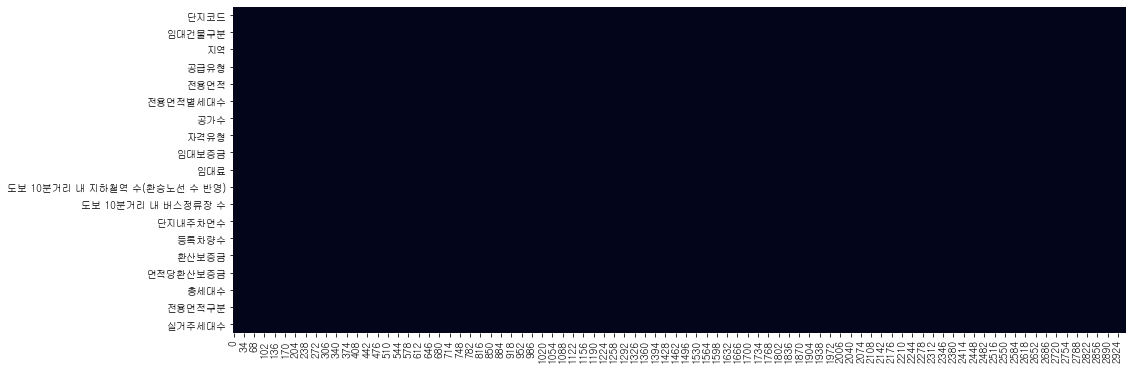

In [202]:
plt.figure(figsize=(16, 6))
sns.heatmap(train.isnull().T, cbar=False)
plt.show()

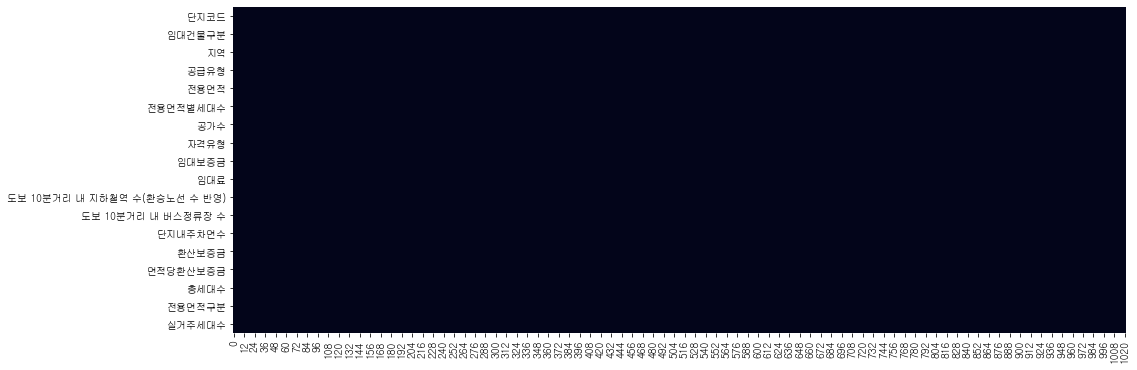

In [203]:
plt.figure(figsize=(16, 6))
sns.heatmap(test.isnull().T, cbar=False)
plt.show()

# MODELING

In [223]:
def make_train_test(train):

    train_preprocessed = train.copy()

    train_preprocessed.drop(['전용면적', '공가수', '임대보증금', '임대료', '환산보증금', '총세대수'], axis=1, inplace=True)
    train_preprocessed = train_preprocessed.loc[train_preprocessed['임대건물구분'] == '아파트', ~train_preprocessed.columns.isin(['임대건물구분'])]

    temp = train_preprocessed.groupby(['단지코드', '전용면적구분'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['전용면적구분'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '공급유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['공급유형'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드', '자격유형'])['전용면적별세대수'].sum().unstack().fillna(0)
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['자격유형', '전용면적별세대수'])], temp, on='단지코드')

    temp = train_preprocessed.groupby(['단지코드'])['면적당환산보증금'].mean().reset_index()
    train_preprocessed = pd.merge(train_preprocessed.loc[:, ~train_preprocessed.columns.isin(['면적당환산보증금'])], temp, on='단지코드')

    train_preprocessed = train_preprocessed.drop_duplicates()
    
    #train_preprocessed.drop(['단지코드'], axis=1, inplace=True)
    
    return train_preprocessed

In [224]:
X = make_train_test(train)
y = make_train_test(test)

In [225]:
X.columns

Index(['단지코드', '지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '등록차량수', '실거주세대수', '대형', '소형', '중형', '공공임대', '국민임대', '영구임대',
       '행복주택', 'A', 'C', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       '면적당환산보증금'],
      dtype='object')

In [226]:
y.columns

Index(['단지코드', '지역', '도보 10분거리 내 지하철역 수(환승노선 수 반영)', '도보 10분거리 내 버스정류장 수',
       '단지내주차면수', '실거주세대수', '대형', '소형', '중형', '공공임대', '국민임대', '영구임대', '행복주택',
       'A', 'C', 'E', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', '면적당환산보증금'],
      dtype='object')

In [227]:
X.shape, y.shape

((423, 26), (150, 25))

In [228]:
from sklearn.ensemble import RandomForestRegressor

In [231]:
x_train = X.loc[:, ~X.columns.isin(['단지코드', '등록차량수'])]
y_train = X['등록차량수']
x_test = y.loc[:, ~y.columns.isin(['단지코드'])]

In [232]:
rf = RandomForestRegressor(random_state=42, oob_score=True, criterion='mae', n_estimators=200)
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

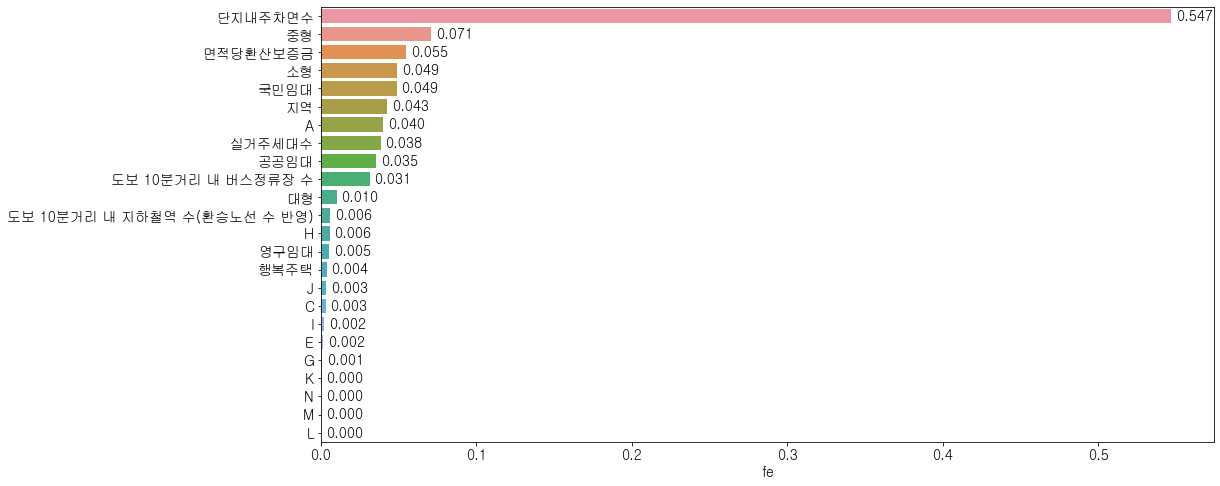

In [233]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams["font.size"] = "14"

fe_avg = pd.DataFrame(rf.feature_importances_,
                      index=x_train.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)

plt.figure(figsize=(16, 8))
plots = sns.barplot(fe_avg.fe, y=fe_avg.index)

# Annotate every single Bar with its value, based on it's width           
for bar in plots.patches:
    width = bar.get_width()
    plt.text(0.015+ bar.get_width(),
             bar.get_y() + 0.5 * bar.get_height(),
             '{:.3f}'.format(width),
             ha='center', va='center')

plt.show()

In [234]:
rf.oob_score_

0.7721442249192785

In [238]:
sub.num = pred

In [243]:
sub.to_csv('submission/parking_210615_vanilaRF.csv', index=False)